# Implementacion de Redes Neuronales

## 1. Introduccion

En esta etapa se implementa un modelo de red neuronal utilizando PyTorch con el objetivo de predecir el precio de las propiedades, para eso se utilizara una arquitectura MLP, adecuada para datos tabulares estructurados. Luego se comparara este modelo contra los modelos clasicos de ML entrenados en dicha etapa.

## 2. Importacion de librerias y carga del dataset procesado

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("..")

In [2]:
df = pd.read_csv('../data/processed/listings_processed.csv')


### 2.1 Separacion de variables

In [5]:
X = df.drop(columns=['price'])  #Features
y = df['price']  #Variable objetivo 

In [6]:
X = X.astype(np.float32)
y = y.astype(np.float32)

In [7]:
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.3 Escalado de datos

Las redes neuronales son sensibles a la escala de los datos, por lo que se aplica estandarización tanto a las variables predictoras como a la variable objetivo.


In [ ]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_original)
X_test  = scaler_X.transform(X_test_original)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_original.values.reshape(-1,1))
y_test  = scaler_y.transform(y_test_original.values.reshape(-1,1))

### 2.4 Conversion a tensores de PyTorch

Los datos deben convertirse a tensores para poder ser utilizados por el modelo.


In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)


## 3. Definicion del modelo

### 3.1 Importacion de modulos desde src

Se importa la arquitectura MLP definida en `src/deep_learning/mlp/model_mlp.py` y la función de entrenamiento definida en `src/deep_learning/mlp/train_mlp.py`.

In [10]:
from src.deep_learning.mlp.model_mlp import MLPRegressor
from src.deep_learning.mlp.train_mlp import train_model_mlp


### 3.2 Inicializacion de modelo 

Dimension de entrada en funcion del numero de variables predictoras.

In [11]:
input_dim = X_train.shape[1]
model = MLPRegressor(input_dim)

## 4. Entrenamiento del modelo

Se entrena el modelo utilizando función de pérdida MSE y optimizador Adam.

In [12]:
model = train_model_mlp(model,
                    X_train,
                    y_train, 
                    epochs=500,
                    lr=0.0007)

Epoch [20/500] Loss: 0.9279
Epoch [40/500] Loss: 0.8032
Epoch [60/500] Loss: 0.6333
Epoch [80/500] Loss: 0.5934
Epoch [100/500] Loss: 0.5678
Epoch [120/500] Loss: 0.5540
Epoch [140/500] Loss: 0.5417
Epoch [160/500] Loss: 0.5363
Epoch [180/500] Loss: 0.5238
Epoch [200/500] Loss: 0.5157
Epoch [220/500] Loss: 0.5094
Epoch [240/500] Loss: 0.5014
Epoch [260/500] Loss: 0.4917
Epoch [280/500] Loss: 0.4900
Epoch [300/500] Loss: 0.4769
Epoch [320/500] Loss: 0.4669
Epoch [340/500] Loss: 0.4667
Epoch [360/500] Loss: 0.4665
Epoch [380/500] Loss: 0.4510
Epoch [400/500] Loss: 0.4465
Epoch [420/500] Loss: 0.4496
Epoch [440/500] Loss: 0.4405
Epoch [460/500] Loss: 0.4412
Epoch [480/500] Loss: 0.4372
Epoch [500/500] Loss: 0.4272


## 5.Evaluacion del modelo

### 5.1 Generacion de predicciones

In [13]:
model.eval() #Poner el modelo en modo evaluación

with torch.no_grad(): #Desactivar el cálculo de gradientes
    predictions = model(X_test)     

### 5.2 Reversion del escalado

Las predicciones y valores reales se transforman nuevamente a su escala original para una correcta interpretacion.

In [14]:
preds_real = scaler_y.inverse_transform(predictions.numpy()).flatten()
y_test_real = scaler_y.inverse_transform(y_test.numpy()).flatten()


### 5.3 Metricas

In [15]:
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score

mae_mlp = mean_absolute_error(y_test_real,preds_real)
rmse_mlp = root_mean_squared_error(y_test_real,preds_real)
r2_mlp = r2_score(y_test_real,preds_real)

print(f"MAE Multilayer Perceptron: {mae_mlp:.2f}")
print(f"RMSE Multilayer Perceptron: {rmse_mlp:.2f}")
print(f"R2 Multilayer Perceptron: {r2_mlp:.4f}")

MAE Multilayer Perceptron: 1150.51
RMSE Multilayer Perceptron: 2078.15
R2 Multilayer Perceptron: 0.4107


In [16]:
print("Promedio real:", y_test_real.mean().item())
print("Promedio predicho:", preds_real.mean().item())

Promedio real: 2871.589599609375
Promedio predicho: 2814.888671875


## 6. Comparacion con modelos de ML clasicos

### 6.1 Importacion metricas de la etapa 3 y generacion de dataframe 

In [17]:
import json

with open("../models/metrics_etapa3.json", "r") as f:
    metrics_etapa3 = json.load(f) #Cargar métricas anteriores de la etapa 3

print(type(metrics_etapa3))  

<class 'dict'>


In [18]:
metrics_etapa4 = {
    "MultiLayerPerceptron": {
        "R2": r2_mlp,
        "MAE": mae_mlp,
        "RMSE": rmse_mlp
    }
}

metrics = {**metrics_etapa3, **metrics_etapa4}  #Combinar métricas de ambas etapas

In [19]:
results = pd.DataFrame.from_dict(
	{
		modelo: {"R2": metrica["R2"], "MAE": metrica["MAE"]}
		for modelo, metrica in metrics.items()  
	},
	orient='index'
).reset_index().rename(columns={'index': 'Modelo'})

results = results.sort_values(by='R2', ascending=False).round(2)
results

,Modelo,R2,MAE
4,XGBoost Optimizado,0.46,1113.84
3,XGBoost,0.43,1154.71
2,Random Forest,0.42,1157.91
5,MultiLayerPerceptron,0.41,1150.51
1,Decision Tree,0.37,1223.32
0,Linear Regression,0.30,1313.54


### 6.2 Grafico comparativo R2

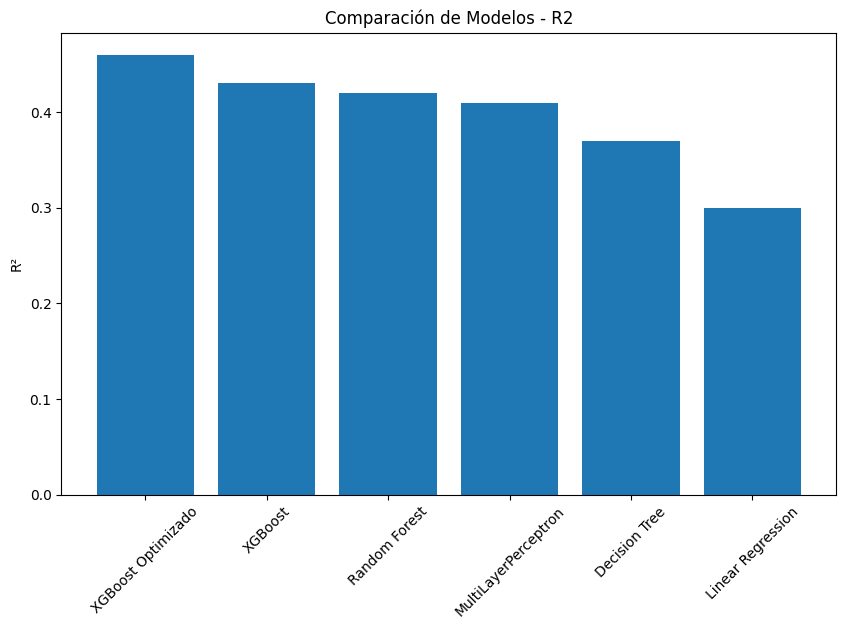

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(results['Modelo'],results['R2'])
plt.xticks(rotation=45)
plt.title('Comparación de Modelos - R2')
plt.ylabel('R²')
plt.show()

### 6.3 Grafico comparativo MAE

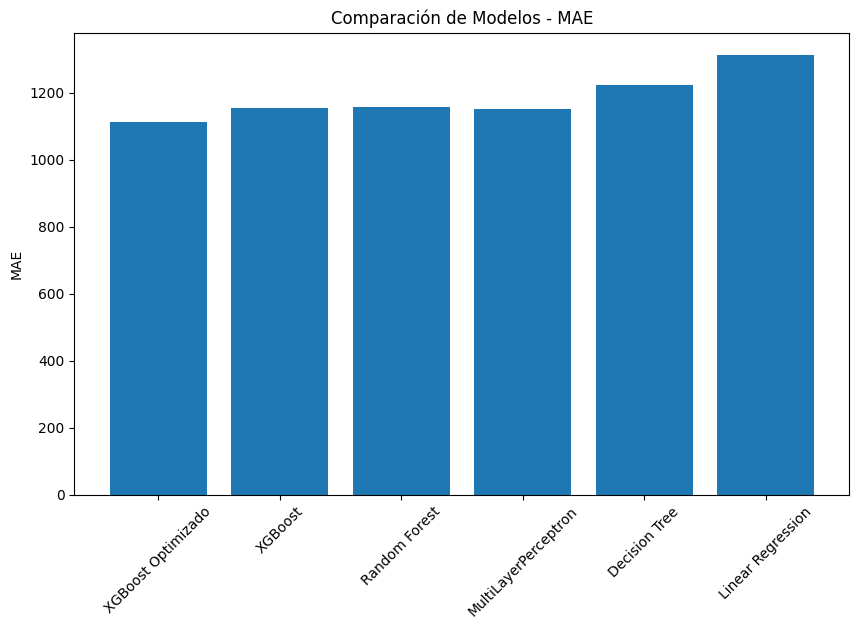

In [21]:
plt.figure(figsize=(10,6))
plt.bar(results['Modelo'],results['MAE'])
plt.xticks(rotation=45)
plt.title('Comparación de Modelos - MAE')
plt.ylabel('MAE')
plt.show()

### 6.4 Grafico real vs predicho (MLP)

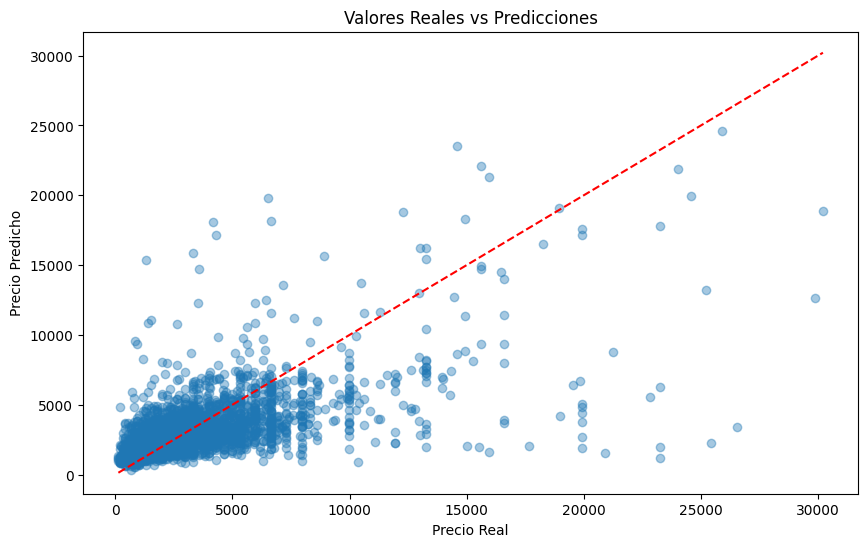

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_real, preds_real, alpha=0.4)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')  # Línea de referencia
plt.title('Valores Reales vs Predicciones') 
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.show()

In [23]:
import joblib

xgb_best = joblib.load("../models/xgb_optimizado_v1.pkl")


In [24]:
y_pred_best_xgb = xgb_best.predict(X_test_original)

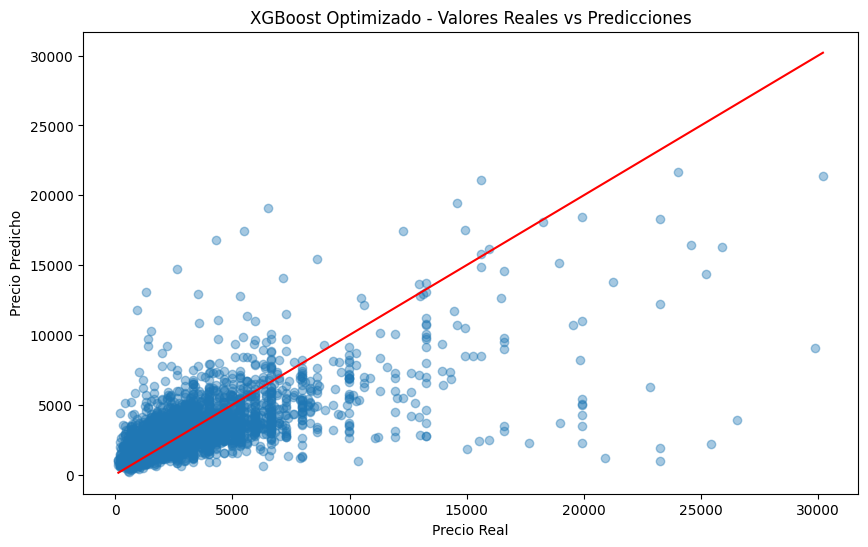

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_original, y_pred_best_xgb, alpha=0.4)
plt.plot(
    [y_test_original.min(), y_test_original.max()],
    [y_test_original.min(), y_test_original.max()],
    color='red'
)
plt.title("XGBoost Optimizado - Valores Reales vs Predicciones")
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.show()


La red neuronal multicapa (MLP) alcanzó un desempeño competitivo (R² ≈ 0.40), mostrando capacidad para capturar relaciones no lineales en los datos. Sin embargo, el modelo XGBoost obtuvo un rendimiento superior (R² ≈ 0.45), lo que confirma que en datasets tabulares estructurados los métodos basados en boosting suelen presentar mayor capacidad predictiva.

Esto se debe a que los modelos de boosting optimizan secuencialmente los errores residuales y están especialmente diseñados para trabajar con variables estructuradas y heterogéneas, mientras que las redes neuronales feedforward tienden a mostrar mayor ventaja en problemas con datos no estructurados como imágenes o texto.

El modelo XGBoost optimizado muestra una mayor concentración de predicciones cercanas a la línea de referencia (y = x), particularmente en el rango de precios más frecuente. Sin embargo, se observa una tendencia a subestimar propiedades de precio elevado, lo cual es consistente con la distribución sesgada del target y la menor cantidad de ejemplos extremos en el dataset.